In [ ]:
!pip install -q dalle-mini
# !pip install -q git+https://github.com/patil-suraj/vqgan-jax.git

!pip uninstall -y jax jaxlib
!pip install jax==0.3.25 jaxlib==0.3.25

import jax

In [ ]:

import jax.numpy as jnp

# Check how many devices are available
print(jax.local_device_count())

jax.devices()

In [ ]:
!ls -la ~/.cache/wandb/artifacts/obj/md5


In [ ]:
!du -sh ~/.cache/wandb/artifacts/obj/md5

In [ ]:
# VQGAN model
VQGAN_REPO = "dalle-mini/vqgan_imagenet_f16_16384"
VQGAN_COMMIT_ID = "e93a26e7707683d349bf5d5c41c5b0ef69b677a9"

# Load VQGAN
vqgan, vqgan_params = VQModel.from_pretrained(
    VQGAN_REPO, revision=VQGAN_COMMIT_ID, _do_init=False
)

In [ ]:
from flax.jax_utils import replicate

params = replicate(params)
vqgan_params = replicate(vqgan_params)

# Cast params to float32 if they are not already
params = jax.tree_map(lambda x: x.astype(jnp.float32), params)
vqgan_params = jax.tree_map(lambda x: x.astype(jnp.float32), vqgan_params)


In [ ]:
from functools import partial

# model inference
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4, 5, 6))
def p_generate(
    tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale
):
    tokenized_prompt = jax.tree_map(lambda x: x.astype(jnp.float32) if x.dtype == jnp.float16 else x, tokenized_prompt)
    return model.generate(
        **tokenized_prompt,
        prng_key=key,
        params=params,
        top_k=top_k,
        top_p=top_p,
        temperature=temperature,
        condition_scale=condition_scale,
    )

# decode image
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)


In [ ]:
import random

# create a random key
seed = random.randint(0, 2**32 - 1)
key = jax.random.PRNGKey(seed)

processor = DalleBartProcessor.from_pretrained(DALLE_MODEL, revision=DALLE_COMMIT_ID)

prompts = ['make a monkey eating something.']

tokenized_prompts = processor(prompts)
tokenized_prompts = jax.tree_map(lambda x: x.astype(jnp.float32) if x.dtype == jnp.float16 else x, tokenized_prompts)
tokenized_prompt = replicate(tokenized_prompts)

# number of predictions per prompt
n_predictions = 1

# We can customize generation parameters (see https://huggingface.co/blog/how-to-generate)
gen_top_k = None
gen_top_p = None
temperature = None
cond_scale = 10.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
orbax-checkpoint 0.4.4 requires jax>=0.4.9, but you have jax 0.3.25 which is incompatible.
Found existing installation: jax 0.3.25
Uninstalling jax-0.3.25:
  Successfully uninstalled jax-0.3.25
Found existing installation: jaxlib 0.4.30
Uninstalling jaxlib-0.4.30:
  Successfully uninstalled jaxlib-0.4.30
  Using cached jax-0.3.25-py3-none-any.whl
ERROR: Could not find a version that satisfies the requirement jaxlib==0.3.25 (from versions: 0.4.6, 0.4.7, 0.4.9, 0.4.10, 0.4.11, 0.4.12, 0.4.13, 0.4.14, 0.4.16, 0.4.17, 0.4.18, 0.4.19, 0.4.20, 0.4.21, 0.4.22, 0.4.23, 0.4.24, 0.4.25, 0.4.26, 0.4.27, 0.4.28, 0.4.29, 0.4.30)
ERROR: No matching distribution found for jaxlib==0.3.25
1


wandb: Downloading large artifact mini-1:v0, 1673.43MB. 7 files... 
wandb:   7 of 7 files downloaded.  
Done. 0:0:19.3


total 36
drwxr-xr-x 9 root root 4096 Jul  8 19:42 .
drwxr-xr-x 3 root root 4096 Jul  8 19:41 ..
drwxr-xr-x 2 root root 4096 Jul  8 19:41 17
drwxr-xr-x 2 root root 4096 Jul  8 19:41 1f
drwxr-xr-x 2 root root 4096 Jul  8 19:41 32
drwxr-xr-x 2 root root 4096 Jul  8 19:41 52
drwxr-xr-x 2 root root 4096 Jul  8 19:41 78
drwxr-xr-x 2 root root 4096 Jul  8 19:42 e9
drwxr-xr-x 2 root root 4096 Jul  8 19:41 f1
1.7G	/root/.cache/wandb/artifacts/obj/md5


wandb: Downloading large artifact mini-1:v0, 1673.43MB. 7 files... 
wandb:   7 of 7 files downloaded.  
Done. 0:0:31.1


Prompts: ['make a monkey eating something.']



  0%|          | 0/1 [00:00<?, ?it/s]

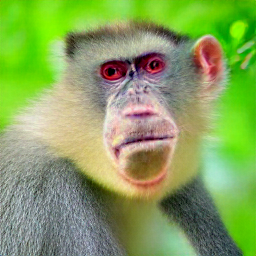

In [ ]:
from flax.training.common_utils import shard_prng_key
import numpy as np
from PIL import Image
from tqdm.notebook import trange

print(f"Prompts: {prompts}\n")
# generate images
images = []
for i in trange(max(n_predictions // jax.device_count(), 1)):
    # get a new key
    key, subkey = jax.random.split(key)
    # generate images
    encoded_images = p_generate(
        tokenized_prompt,
        shard_prng_key(subkey),
        params,
        gen_top_k,
        gen_top_p,
        temperature,
        cond_scale,
    )
    # remove BOS
    encoded_images = encoded_images.sequences[..., 1:]
    # decode images
    decoded_images = p_decode(encoded_images, vqgan_params)
    decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
    for decoded_img in decoded_images:
        img = Image.fromarray(np.asarray(decoded_img * 255, dtype=np.uint8))
        images.append(img)
        display(img)
        print()